## Set up imports

In [13]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight
import os
from math import ceil
import time
import sys
#import tensorflow_addons as tfa
#from tensorflow.python.compiler.mlcompute import mlcompute

## Set up global variables

In [38]:
#couple of lines to force gpu usage
#tf.compat.v1.disable_eager_execution()
#mlcompute.set_mlc_device(device_name="gpu")

#SET UP GLOBAL VARIABLES
sub_matrix_size=128
BATCH_SIZE=64
EPOCHS=100
SPLIT_SIZE=0.2
time_variable=int(time.time())
NAME=f"2024_Conv2D_dmca_multiclass_norm_filesplit_s{sub_matrix_size}_b{BATCH_SIZE}_e{EPOCHS}_split{SPLIT_SIZE}_{time_variable}_diagonal_checkpoint"
#NAME=f"TESTnoise0.0001_lowerlr_2024_04_09_Conv2D_dmca_multiclass_norm_filesplit_s{sub_matrix_size}_b{BATCH_SIZE}_e{EPOCHS}_split{SPLIT_SIZE}_{time_variable}_diagonal_01mar2023"

## Set up directories

In [15]:
dataset_directory = "/Users/georginikov/Documents/Dataset/dataset_tosatto/"
dataset_directory_short='/Users/georginikov/Documents/Dataset/'

## Set up code

In [29]:
class Dataset:

    def __init__(self, dataset_directory):

        self.dataset_directory=dataset_directory

        #set up arrays holding paths to distance matrices/labels

        self.x_train_total=np.array([])
        self.x_test_total=np.array([])
        self.y_train_total=np.array([])
        self.y_test_total=np.array([])

        #set up arrays holding final train/val concatenated distance matrices and labels

        self.distance_matrices_train=[]
        self.distance_matrices_test=[]
        self.labels_train=[]
        self.labels_test=[]


    #populate arrays with paths to distance matrices/labels for train/val sets

    def get_split_files(self,test_size):
        for subdirectory in os.listdir(self.dataset_directory):
            if subdirectory not in ['propeller','beta_sandwich_repeat','.DS_Store']:
                sub_subdirectory_path=os.path.join(self.dataset_directory,subdirectory)
                dm_file=np.loadtxt(str(sub_subdirectory_path) + "/distance_matrix_list.txt", dtype="str")
                labels_file=np.loadtxt(str(sub_subdirectory_path) + "/labels_list.txt", dtype="str")
                x_train,x_test,y_train,y_test=train_test_split(dm_file, labels_file, test_size=test_size,shuffle=True,random_state=42)

                self.x_train_total=np.append(self.x_train_total, x_train)
                self.x_test_total=np.append(self.x_test_total, x_test)
                self.y_train_total=np.append(self.y_train_total, y_train)
                self.y_test_total=np.append(self.y_test_total, y_test)


    # populate final train/val concatenated distance matrices and labels

    def set_data(self, sub_matrix_size=sub_matrix_size):

        #Function to split distance matrix into diagonal chunks of size sub_matrix_size
        #with an overlap of sub_matrix_size/2

        def diagonal_split(matrix,sub_matrix_size):
            half_sub_matrix=int(sub_matrix_size/2)
            slices=[]
            for i in range(0,len(matrix)-half_sub_matrix,half_sub_matrix):
                slices.append(matrix[i:i+sub_matrix_size,i:i+sub_matrix_size])
            return np.asarray(slices)

        #Function to split segmentation mask into diagonal non-overlapping chunks of
        #size sub_matrix_size/2

        def diagonal_split2(matrix,sub_matrix_size):
            half_sub_matrix=int(sub_matrix_size/2)
            slices=[]
            for i in range(0,len(matrix)-half_sub_matrix,half_sub_matrix):
                slices.append(matrix[i:i+sub_matrix_size,i:i+sub_matrix_size][32:96,32:96])
            return np.asarray(slices)

        #Function to produce random crops of distance matrix and segmentation
        #mask along the diagonal

        def random_diag_crop(img, mask, sub_matrix_size=sub_matrix_size):
                assert img.shape[0] >= sub_matrix_size
                assert img.shape[1] >= sub_matrix_size
                assert img.shape[0] == mask.shape[0]
                assert img.shape[1] == mask.shape[1]
                x = np.random.randint(0, img.shape[1] - sub_matrix_size)
                img = img[x:x+sub_matrix_size, x:x+sub_matrix_size]
                mask = mask[x:x+sub_matrix_size, x:x+sub_matrix_size][32:96,32:96]
                return img, mask

        #ITERATE THROUGH TRAIN STRUCTURES

        for index, line in enumerate(self.x_train_total):

            # PROCESS DISTANCE MATRICES

            # load distance matrix

            distance_matrix = np.loadtxt(dataset_directory_short+line, dtype="float", delimiter=",")

            # obtain values to pad with

            dm_div = len(distance_matrix)/sub_matrix_size
            if dm_div<1:
                pad_value=int(sub_matrix_size-len(distance_matrix))+64
            else:
                pad_value = int(((ceil(dm_div) - dm_div)*sub_matrix_size))
            half_pad=int(pad_value/2)
            lpad=half_pad+int(sub_matrix_size/4)
            rpad=pad_value-half_pad+int(sub_matrix_size/4)

            # pad distance matrix

            distance_matrix_padded = np.pad(distance_matrix, ((lpad, rpad), (lpad, rpad)), 'constant', constant_values=(0, 0))

            # normalise distance matrix between 0 and 1

            distance_matrix_padded = distance_matrix_padded/np.max(distance_matrix_padded)


            # PROCESS LABELS

            # load and reshape labels

            labels = np.loadtxt(dataset_directory_short+self.y_train_total[index], dtype="float", delimiter=",")
            labels = np.reshape(labels, (len(labels), 1))

            # turn labels into a matrix

            labels_matrix = np.multiply(labels, labels.reshape(1, len(labels)))**(1/2)

            # pad edges with zeros

            labels_matrix_padded = np.pad(labels_matrix, ((lpad, rpad), (lpad, rpad)), 'constant', constant_values=(0, 0))

            # get rows and column indices where distance matrix has all 0s

            zero_rows = np.all((distance_matrix_padded == 0), axis=1)
            zero_row_indices = [i for i in range(len(zero_rows)) if zero_rows[i] == True]
            zero_cols = np.all((distance_matrix_padded == 0), axis=0)
            zero_col_indices = [i for i in range(len(zero_cols)) if zero_cols[i] == True]

            # remove these from the inverted matrix

            for x in range(len(labels_matrix_padded)):
                for y in zero_row_indices:
                    labels_matrix_padded[x,y]=4
                    labels_matrix_padded[y,x]=4
            

            number_of_crops=((distance_matrix_padded.shape[0]/sub_matrix_size)*2)**2
            init_num=0
            while init_num<number_of_crops:
                random_crop_dm,random_crop_label=random_diag_crop(distance_matrix_padded,labels_matrix_padded,sub_matrix_size=sub_matrix_size)
                unique, counts = np.unique(random_crop_label, return_counts=True)
                counts_dict=dict(zip(unique, counts))
                self.distance_matrices_train.append(random_crop_dm)
                self.labels_train.append(random_crop_label)
                init_num+=1
                '''
                if 4 in counts_dict.keys():
                    if counts_dict[4]/np.sum(counts)<0.5:
                        self.distance_matrices_train.append(random_crop_dm)
                        self.labels_train.append(random_crop_label)
                        init_num+=1
                    elif counts_dict[4]/np.sum(counts)>=0.5:
                        init_num+=1
                        
                else:
                
                # append split up distance matrix to list

                    self.distance_matrices_train.append(random_crop_dm)
                    self.labels_train.append(random_crop_label)
                    init_num+=1
                '''

        #ITERATE THROUGH TEST STRUCTURES

        for index, line in enumerate(self.x_test_total):

            # PROCESS DISTANCE MATRICES

            # load distance matrix

            distance_matrix = np.loadtxt(dataset_directory_short+line, dtype="float", delimiter=",")

            # obtain values to pad with

            dm_div = len(distance_matrix)/sub_matrix_size
            pad_value = int(((ceil(dm_div) - dm_div)*sub_matrix_size))
            half_pad=int(pad_value/2)
            lpad=half_pad+int(sub_matrix_size/4)
            rpad=pad_value-half_pad+int(sub_matrix_size/4)

            # pad distance matrix

            distance_matrix_padded = np.pad(distance_matrix, ((lpad, rpad), (lpad, rpad)), 'constant', constant_values=(0, 0))

            # normalise distance matrix between 0 and 1

            distance_matrix_padded = distance_matrix_padded/np.max(distance_matrix_padded)

            # PROCESS LABELS

            # load and reshape labels

            labels = np.loadtxt(dataset_directory_short+self.y_test_total[index], dtype="float", delimiter=",")
            labels = np.reshape(labels, (len(labels), 1))

            # turn labels into a matrix

            labels_matrix = np.multiply(labels, labels.reshape(1, len(labels)))**(1/2)

            # pad edges with zeros

            labels_matrix_padded = np.pad(labels_matrix, ((lpad, rpad), (lpad, rpad)), 'constant', constant_values=(0, 0))

            # get rows and column indices where distance matrix has all 0s

            zero_rows = np.all((distance_matrix_padded == 0), axis=1)
            zero_row_indices = [i for i in range(len(zero_rows)) if zero_rows[i] == True]
            zero_cols = np.all((distance_matrix_padded == 0), axis=0)
            zero_col_indices = [i for i in range(len(zero_cols)) if zero_cols[i] == True]

            # remove these from the inverted matrix

            for x in range(len(labels_matrix_padded)):
                for y in zero_row_indices:
                    labels_matrix_padded[x,y]=4
                    labels_matrix_padded[y,x]=4

            # split up distance matrix into 32x32 squares

            print(distance_matrix_padded.shape)
            distance_matrix_reshaped = diagonal_split(distance_matrix_padded, sub_matrix_size)
            print(distance_matrix_reshaped.shape)

            # append split up distance matrix to list
            self.distance_matrices_test.append(distance_matrix_reshaped)

            # split up labels matrix into 32x32 squares
            labels_matrix_reshaped = diagonal_split2(labels_matrix_padded, sub_matrix_size)

            self.labels_test.append(labels_matrix_reshaped)

        self.distance_matrices_train = np.asarray(self.distance_matrices_train)
        self.distance_matrices_train=self.distance_matrices_train.reshape((self.distance_matrices_train.shape[0],self.distance_matrices_train.shape[1],self.distance_matrices_train.shape[2],1))
        self.labels_train = np.asarray(self.labels_train)
        for i in self.distance_matrices_test:
            print(i.shape)
        #self.distance_matrices_test = np.asarray(self.distance_matrices_test)
        self.distance_matrices_test = np.concatenate(self.distance_matrices_test, axis=0)
        print(self.distance_matrices_test.shape)
        self.distance_matrices_test=self.distance_matrices_test.reshape((self.distance_matrices_test.shape[0],self.distance_matrices_test.shape[1],self.distance_matrices_test.shape[2],1))

        #self.labels_test = np.asarray(self.labels_test)
        self.labels_test = np.concatenate(self.labels_test, axis=0)
        self.labels_train = tf.keras.utils.to_categorical(self.labels_train, 6)
        self.labels_test = tf.keras.utils.to_categorical(self.labels_test, 6)

    def autorun(self, test_size):
        self.get_split_files(test_size)
        self.set_data()
        return self.distance_matrices_train, self.distance_matrices_test, self.labels_train, self.labels_test


In [37]:
class Conv2D_Model:

    # set model parameters

    def __init__(self, batch_size, epochs, dataset):
        self.batch_size = batch_size
        self.epochs = epochs
        self.dataset = dataset
        self.callbacks = []

    def get_model(self):

        # set up model architecture

        inputs = tf.keras.layers.Input(shape=(sub_matrix_size, sub_matrix_size, 1))
        noise = tf.keras.layers.GaussianNoise(stddev=0.0001)(inputs)

        c1 = tf.keras.layers.Conv2D(16, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(noise)
        c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1 = tf.keras.layers.Conv2D(16, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c1)
        p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

        c2 = tf.keras.layers.Conv2D(32, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(p1)
        c2 = tf.keras.layers.Dropout(0.1)(c2)
        c2 = tf.keras.layers.Conv2D(32, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c2)
        p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

        c3 = tf.keras.layers.Conv2D(64, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(p2)

        c3 = tf.keras.layers.Dropout(0.2)(c3)
        c3 = tf.keras.layers.Conv2D(64, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c3)
        p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

        c4 = tf.keras.layers.Conv2D(128, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(p3)

        c4 = tf.keras.layers.Dropout(0.2)(c4)
        c4 = tf.keras.layers.Conv2D(128, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c4)
        p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

        c5 = tf.keras.layers.Conv2D(256, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(p4)

        c5 = tf.keras.layers.Dropout(0.3)(c5)
        c5 = tf.keras.layers.Conv2D(256, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c5)

        u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2),
                                             padding='same')(c5)
        u6 = tf.keras.layers.concatenate([u6, c4])
        c6 = tf.keras.layers.Conv2D(128, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(u6)

        c6 = tf.keras.layers.Dropout(0.2)(c6)
        c6 = tf.keras.layers.Conv2D(128, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c6)

        u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2),
                                             padding='same')(c6)
        u7 = tf.keras.layers.concatenate([u7, c3])
        c7 = tf.keras.layers.Conv2D(64, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(u7)

        c7 = tf.keras.layers.Dropout(0.2)(c7)
        c7 = tf.keras.layers.Conv2D(64, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c7)

        u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2),
                                             padding='same')(c7)
        u8 = tf.keras.layers.concatenate([u8, c2])
        c8 = tf.keras.layers.Conv2D(32, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(u8)

        c8 = tf.keras.layers.Dropout(0.1)(c8)
        c8 = tf.keras.layers.Conv2D(32, (3, 3),
                                    activation=tf.keras.activations.elu,
                                    kernel_initializer='he_normal',
                                    padding='same')(c8)
        outputs = tf.keras.layers.Conv2D(6, (1, 1),
                                        activation='softmax')(c8)

        model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
        model.summary()
        return model

    # set up early stopping callback and model saving callback

    def get_callbacks(self):

        early_stopping = EarlyStopping(monitor='val_loss',
                                       mode='min', verbose=1, patience=50)
        mc = ModelCheckpoint(
             f'{NAME}_checkpoint.h5',
             save_best_only=True, monitor='val_loss',
             mode='min', verbose=1)
        self.callbacks.append(early_stopping)
        self.callbacks.append(mc)

    def compile_build_train(self):

        # set up model and compile

        model = self.get_model()
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                                loss=tf.keras.losses.CategoricalCrossentropy(),
                                metrics=[tf.keras.metrics.Accuracy(),
                                         tf.keras.metrics.Recall(),
                                         tf.keras.metrics.Precision()])

        # get train/val data
        x_train, x_test, y_train, y_test = self.dataset.autorun(SPLIT_SIZE)



        # train model

        history = model.fit(x_train, y_train,
                            epochs=self.epochs,
                            batch_size=self.batch_size,
                            validation_data=(x_test, y_test),
                            callbacks=self.callbacks)

        # save history dictionary to plot model learning curves later
        
        np.save(f'{NAME}_history.npy',
                history.history)

## Check dataset and train/validation split

Dataset and train/validation split

In [30]:
dataset1=Dataset(dataset_directory)

In [31]:
x_train, x_test, y_train, y_test = dataset1.autorun(SPLIT_SIZE)


(320, 320)
(4, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(704, 704)
(10, 128, 128)
(576, 576)
(8, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(576, 576)
(8, 128, 128)
(576, 576)
(8, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)
(448, 448)
(6, 128, 128)
(320, 320)
(4, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(320, 320)
(4, 128, 128)
(448, 448)
(6, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)
(448, 448)
(6, 128, 128)
(320, 320)
(4, 128, 128)
(576, 576)
(8, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)
(448, 448)
(6, 128, 128)
(448, 448)
(6, 128, 128)
(576, 576)
(8, 128, 128)
(320, 320)
(4, 128, 128)
(576, 576)
(8, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)
(320, 320)
(4, 128, 128)

Check train/val shapes

In [32]:
print(x_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train.shape)

(11355, 128, 128, 1)
(390, 128, 128, 1)
(390, 64, 64, 6)
(11355, 64, 64, 6)


Check X_train and Y_train samples

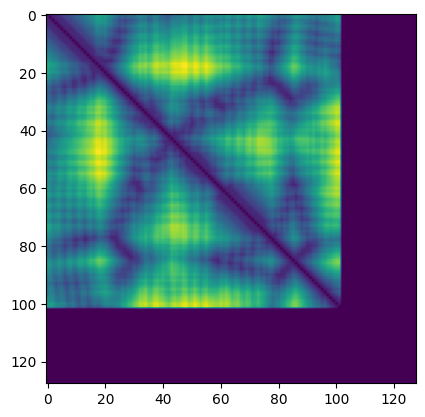

In [35]:
plt.imshow(x_train[8699])

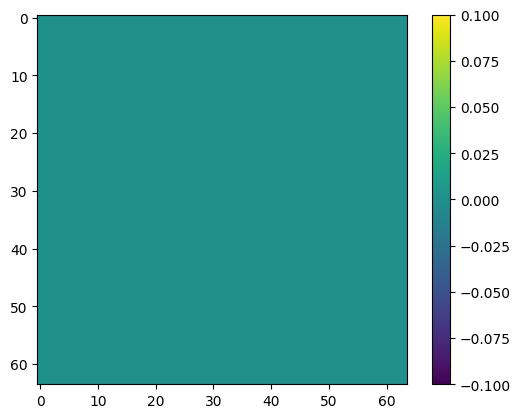

In [36]:
plt.imshow(np.argmax(y_train[8699],axis=2))
plt.colorbar()

## Train model

In [39]:
dataset1 = Dataset(dataset_directory)
model1 = Conv2D_Model(batch_size=BATCH_SIZE, epochs=EPOCHS, dataset=dataset1)
model1.get_callbacks()
model1.compile_build_train()

Metal device set to: Apple M1


2025-07-05 14:31:06.768267: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-05 14:31:06.769937: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 128, 128, 1)  0          ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['gaussian_noise[0][0]']         
                                )                                                                 
                                                                                              

2025-07-05 14:31:19.157161: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-07-05 14:31:20.326266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


178/178 [==============================] - ETA: 0s - loss: 0.6413 - accuracy: 2.6768e-05 - recall: 0.7162 - precision: 0.8591

2025-07-05 14:33:01.460523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.39607, saving model to 2024_Conv2D_dmca_multiclass_norm_filesplit_s128_b64_e100_split0.2_1751722204_diagonal_checkpoint_checkpoint.h5
178/178 [==============================] - 104s 551ms/step - loss: 0.6413 - accuracy: 2.6768e-05 - recall: 0.7162 - precision: 0.8591 - val_loss: 1.3961 - val_accuracy: 0.0010 - val_recall: 0.4404 - val_precision: 0.5850
Epoch 2/100
178/178 [==============================] - ETA: 0s - loss: 0.3845 - accuracy: 0.0017 - recall: 0.8224 - precision: 0.8925
Epoch 2: val_loss did not improve from 1.39607
178/178 [==============================] - 100s 562ms/step - loss: 0.3845 - accuracy: 0.0017 - recall: 0.8224 - precision: 0.8925 - val_loss: 1.8115 - val_accuracy: 0.0190 - val_recall: 0.4622 - val_precision: 0.4688
Epoch 3/100
178/178 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.0039 - recall: 0.8880 - precision: 0.9089
Epoch 3: val_loss improved from 1.39607 to 1.17383, saving model to 202

## Quick model test

In [40]:
from tensorflow.keras.models import load_model, Model


Load model

In [46]:
loaded_model=load_model('./2024_Conv2D_dmca_multiclass_norm_filesplit_s128_b64_e100_split0.2_1751722204_diagonal_checkpoint_checkpoint.h5')

Get distance matrix to predict on

In [55]:
x_train_reshaped=x_train[1570].reshape(1,128,128,1)

Make predictions

In [56]:
preds=np.argmax(loaded_model.predict(x_train_reshaped), axis=-1)

1/1 [==============================] - 0s 43ms/step


In [58]:
preds.shape

(1, 64, 64)

Plot ground truth

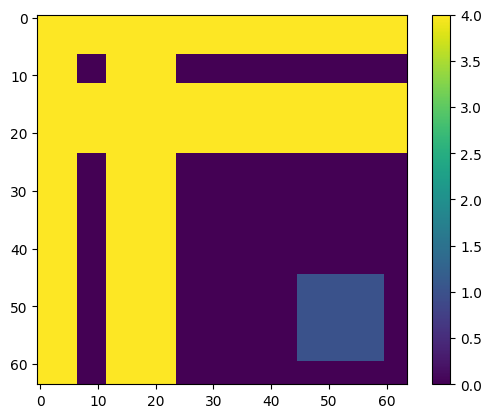

In [59]:
plt.imshow(np.argmax(y_train[1570],axis=-1))
plt.colorbar()

Plot predictions

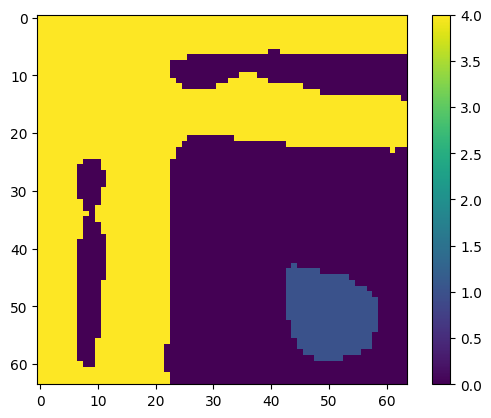

In [60]:
plt.imshow(preds.reshape(64,64))
plt.colorbar()